In [35]:
import requests
import csv
from io import StringIO


In [36]:
#Reading file from https://github.com/MobilityData/gbfs/tree/master
discovery_url = "https://raw.githubusercontent.com/MobilityData/gbfs/master/systems.csv"
response = requests.get(discovery_url)

In [37]:
if response.status_code == 200:
    csv_data = csv.DictReader(StringIO(response.text))
    all_systems = list(csv_data)  # Convert to list to store
    print(f"Loaded {len(all_systems)} systems")

    if all_systems:
        print("\nAvailable columns:")
        print(list(all_systems[0].keys()))
else:
    print(f"Error: Received status code {response.status_code}")

Loaded 1246 systems

Available columns:
['Country Code', 'Name', 'Location', 'System ID', 'URL', 'Auto-Discovery URL', 'Supported Versions', 'Authentication Info URL', 'Authentication Type', 'Authentication Parameter Name']


In [40]:
us_systems = [row for row in all_systems if row['Country Code'] == 'US' and row['System ID'].startswith('lyft')]

for system in us_systems:
    print(system)

print(f"\nTotal US systems: {len(us_systems)}")

{'Country Code': 'US', 'Name': 'Bay Wheels', 'Location': 'San Francisco, CA', 'System ID': 'lyft_bay', 'URL': 'https://www.baywheels.com/', 'Auto-Discovery URL': 'https://gbfs.baywheels.com/gbfs/2.3/gbfs.json', 'Supported Versions': '2.3', 'Authentication Info URL': '', 'Authentication Type': '', 'Authentication Parameter Name': ''}
{'Country Code': 'US', 'Name': 'Citi Bike', 'Location': 'New York, NY', 'System ID': 'lyft_nyc', 'URL': 'https://www.citibikenyc.com', 'Auto-Discovery URL': 'https://gbfs.citibikenyc.com/gbfs/2.3/gbfs.json', 'Supported Versions': '2.3', 'Authentication Info URL': '', 'Authentication Type': '', 'Authentication Parameter Name': ''}
{'Country Code': 'US', 'Name': 'Divvy', 'Location': 'Chicago, IL', 'System ID': 'lyft_chi', 'URL': 'https://www.divvybikes.com', 'Auto-Discovery URL': 'https://gbfs.divvybikes.com/gbfs/2.3/gbfs.json', 'Supported Versions': '1.1 ; 2.3', 'Authentication Info URL': '', 'Authentication Type': '', 'Authentication Parameter Name': ''}
{'

In [41]:
for system in us_systems:
    print(f"\n{'='*50}")
    print(f"System: {system['Name']}")
    
    gbfs_response = requests.get(system['Auto-Discovery URL'])
    
    if gbfs_response.status_code == 200:
        gbfs_data = gbfs_response.json()
        feeds = gbfs_data['data']['en']['feeds']
        
        print("Available feeds:")
        for feed in feeds:
            print(f"  - {feed['name']}: {feed['url']}")
    else:
        print(f"Error: Status code {gbfs_response.status_code}")


System: Bay Wheels
Available feeds:
  - gbfs: https://gbfs.lyft.com/gbfs/2.3/bay/gbfs.json
  - system_information: https://gbfs.lyft.com/gbfs/2.3/bay/en/system_information.json
  - station_information: https://gbfs.lyft.com/gbfs/2.3/bay/en/station_information.json
  - station_status: https://gbfs.lyft.com/gbfs/2.3/bay/en/station_status.json
  - free_bike_status: https://gbfs.lyft.com/gbfs/2.3/bay/en/free_bike_status.json
  - system_hours: https://gbfs.lyft.com/gbfs/2.3/bay/en/system_hours.json
  - system_calendar: https://gbfs.lyft.com/gbfs/2.3/bay/en/system_calendar.json
  - system_regions: https://gbfs.lyft.com/gbfs/2.3/bay/en/system_regions.json
  - system_pricing_plans: https://gbfs.lyft.com/gbfs/2.3/bay/en/system_pricing_plans.json
  - system_alerts: https://gbfs.lyft.com/gbfs/2.3/bay/en/system_alerts.json
  - gbfs_versions: https://gbfs.lyft.com/gbfs/2.3/bay/en/gbfs_versions.json
  - vehicle_types: https://gbfs.lyft.com/gbfs/2.3/bay/en/vehicle_types.json

System: Citi Bike
Avail

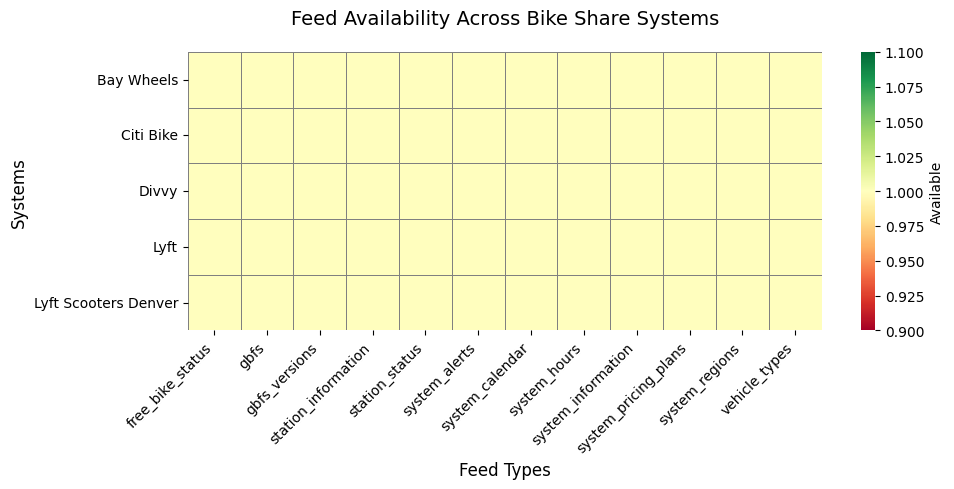


Feed Coverage Summary:
free_bike_status        5
gbfs                    5
gbfs_versions           5
station_information     5
station_status          5
system_alerts           5
system_calendar         5
system_hours            5
system_information      5
system_pricing_plans    5
system_regions          5
vehicle_types           5
dtype: int64


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect data for all systems (THIS WAS MISSING!)
system_feeds = {}

for system in us_systems:
    gbfs_response = requests.get(system['Auto-Discovery URL'])
    
    if gbfs_response.status_code == 200:
        gbfs_data = gbfs_response.json()
        feeds = gbfs_data['data']['en']['feeds']
        feed_names = [feed['name'] for feed in feeds]
        system_feeds[system['Name']] = feed_names

# Get all unique feed types
all_feed_types = set()
for feeds in system_feeds.values():
    all_feed_types.update(feeds)
all_feed_types = sorted(all_feed_types)

# Create matrix: 1 if feed exists, 0 if missing
matrix_data = []
for system_name, feeds in system_feeds.items():
    row = [1 if feed_type in feeds else 0 for feed_type in all_feed_types]
    matrix_data.append(row)

# Create DataFrame
df = pd.DataFrame(matrix_data, 
                  index=list(system_feeds.keys()), 
                  columns=all_feed_types)

# Create heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df, cmap='RdYlGn', cbar_kws={'label': 'Available'}, 
            linewidths=0.5, linecolor='gray')
plt.title('Feed Availability Across Bike Share Systems', fontsize=14, pad=20)
plt.xlabel('Feed Types', fontsize=12)
plt.ylabel('Systems', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary
print("\nFeed Coverage Summary:")
print(df.sum(axis=0).sort_values(ascending=False))

In [43]:
from azure.storage.blob import BlobServiceClient
from datetime import datetime
import json

In [44]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=bikeflowproject;AccountKey=zqgOdUlvtvTRnvgMCV6NQPFh7Qw08D+yufsDepsYzn246/wRdh+wrFO2BS5kNbKYf6Y3umfk/n7s+AStNSE1Rg==;EndpointSuffix=core.windows.net"
container_name = "gbfs-data"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)


In [ ]:
def upload_feed_to_azure(system, feed_name, discovery_url, country_code='us'):
    """Download and upload a single feed to Azure"""
    
    # Fetch the feed data
    response = requests.get(discovery_url)
    if response.status_code != 200:
        print(f"Failed to fetch {feed_name} for {system['Name']}")
        return
    
    feed_data = response.json()
    
    # Create blob path
    system_id = system['System ID']
    timestamp = datetime.utcnow().strftime('%Y-%m-%dT%H-%M-%S')
    
    # Path: raw/us/lyft_nyc/station_status/2024-12-22T10-30-00.json
    blob_path = f"raw/{country_code}/{system_id}/{feed_name}/{timestamp}.json"
    latest_path = f"raw/{country_code}/{system_id}/{feed_name}/latest.json"
    
    # Upload timestamped version
    blob_client = blob_service_client.get_blob_client(
        container=container_name, 
        blob=blob_path
    )
    blob_client.upload_blob(
        json.dumps(feed_data, indent=2), 
        overwrite=True
    )
    print(f"✓ Uploaded: {blob_path}")
    
    # Upload as latest
    latest_client = blob_service_client.get_blob_client(
        container=container_name, 
        blob=latest_path
    )
    latest_client.upload_blob(
        json.dumps(feed_data, indent=2), 
        overwrite=True
    )

In [45]:
for system in us_systems:
    print(f"\n{'='*50}")
    print(f"Processing: {system['Name']}")
    
    gbfs_response = requests.get(system['Auto-Discovery URL'])
    
    if gbfs_response.status_code == 200:
        gbfs_data = gbfs_response.json()
        feeds = gbfs_data['data']['en']['feeds']
        
        for feed in feeds:
            upload_feed_to_azure(system, feed['name'], feed['url'])
    else:
        print(f"Error fetching GBFS for {system['Name']}")


Processing: Bay Wheels


/var/folders/vj/01gy8b_d08q817h1rwc7j8mm0000gn/T/ipykernel_11545/2405506864.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime('%Y-%m-%dT%H-%M-%S')


✓ Uploaded: raw/us/lyft_bay/gbfs/2025-12-23T13-43-41.json
✓ Uploaded: raw/us/lyft_bay/system_information/2025-12-23T13-43-41.json
✓ Uploaded: raw/us/lyft_bay/station_information/2025-12-23T13-43-42.json
✓ Uploaded: raw/us/lyft_bay/station_status/2025-12-23T13-43-42.json
✓ Uploaded: raw/us/lyft_bay/free_bike_status/2025-12-23T13-43-43.json
✓ Uploaded: raw/us/lyft_bay/system_hours/2025-12-23T13-43-43.json
✓ Uploaded: raw/us/lyft_bay/system_calendar/2025-12-23T13-43-43.json
✓ Uploaded: raw/us/lyft_bay/system_regions/2025-12-23T13-43-44.json
✓ Uploaded: raw/us/lyft_bay/system_pricing_plans/2025-12-23T13-43-44.json
✓ Uploaded: raw/us/lyft_bay/system_alerts/2025-12-23T13-43-44.json
✓ Uploaded: raw/us/lyft_bay/gbfs_versions/2025-12-23T13-43-44.json
✓ Uploaded: raw/us/lyft_bay/vehicle_types/2025-12-23T13-43-45.json

Processing: Citi Bike
✓ Uploaded: raw/us/lyft_nyc/gbfs/2025-12-23T13-43-45.json
✓ Uploaded: raw/us/lyft_nyc/system_information/2025-12-23T13-43-45.json
✓ Uploaded: raw/us/lyft_nyc/